c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


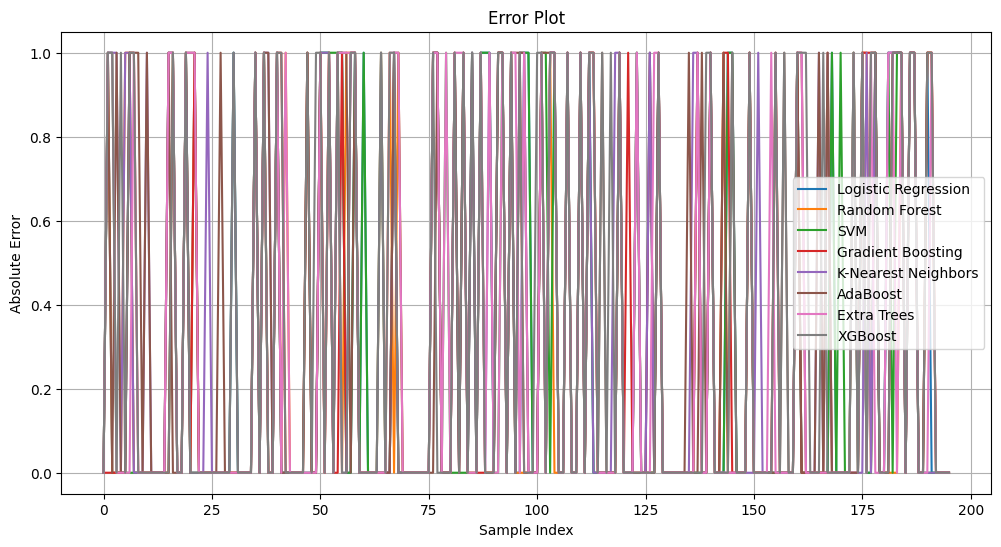

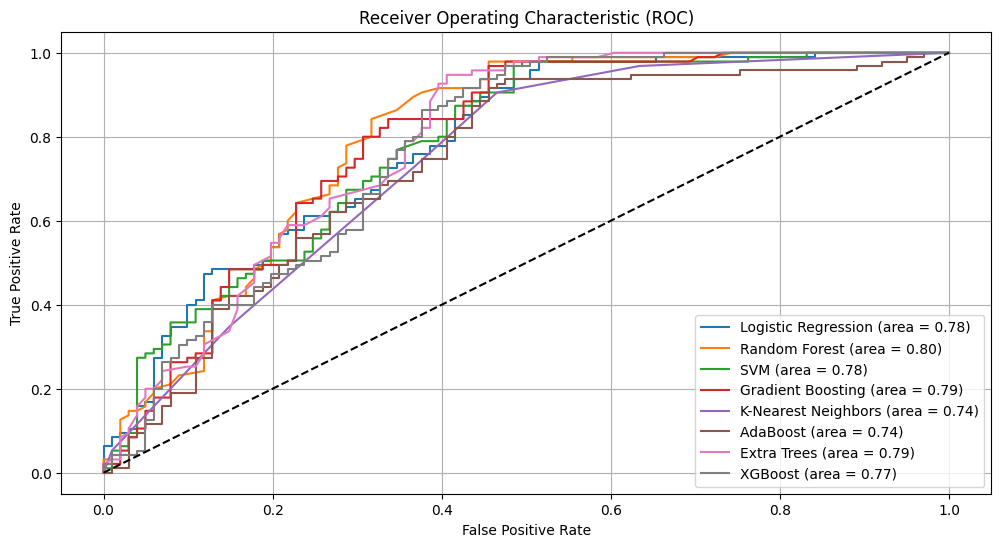

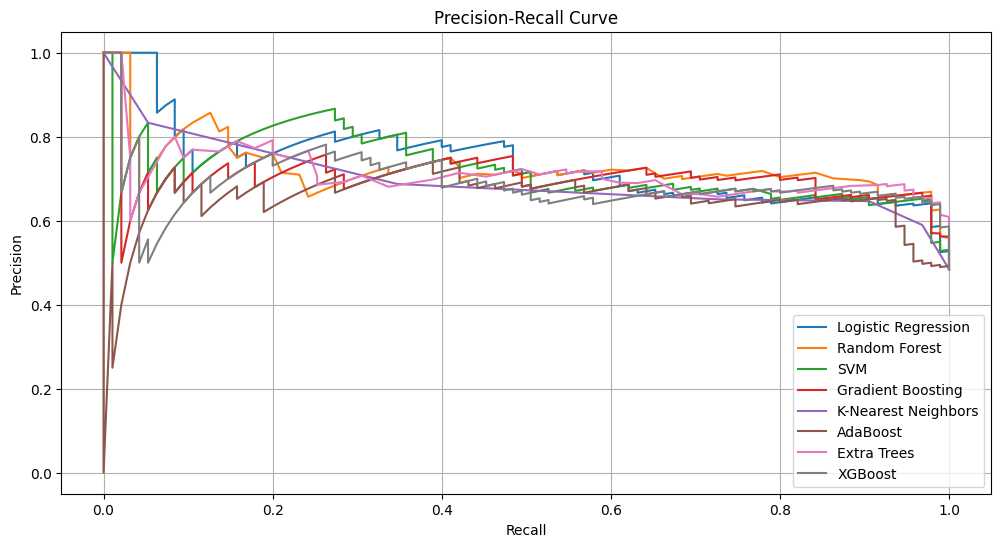

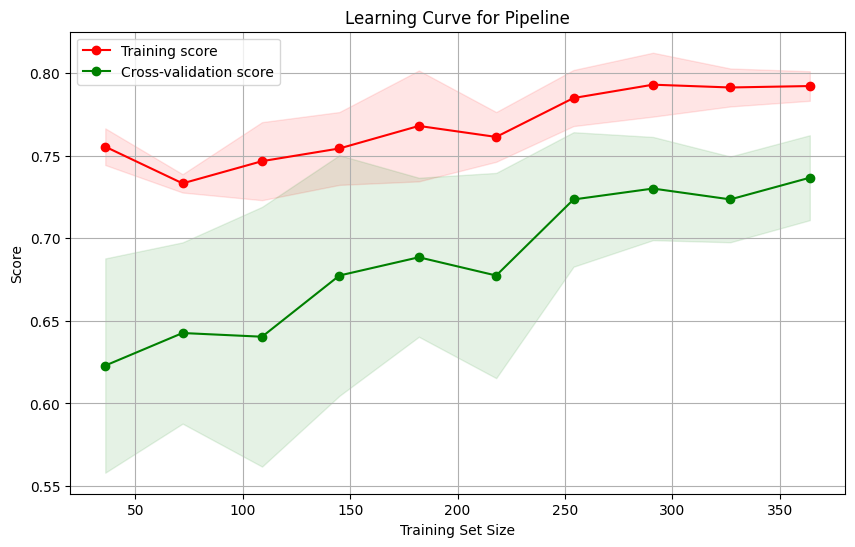

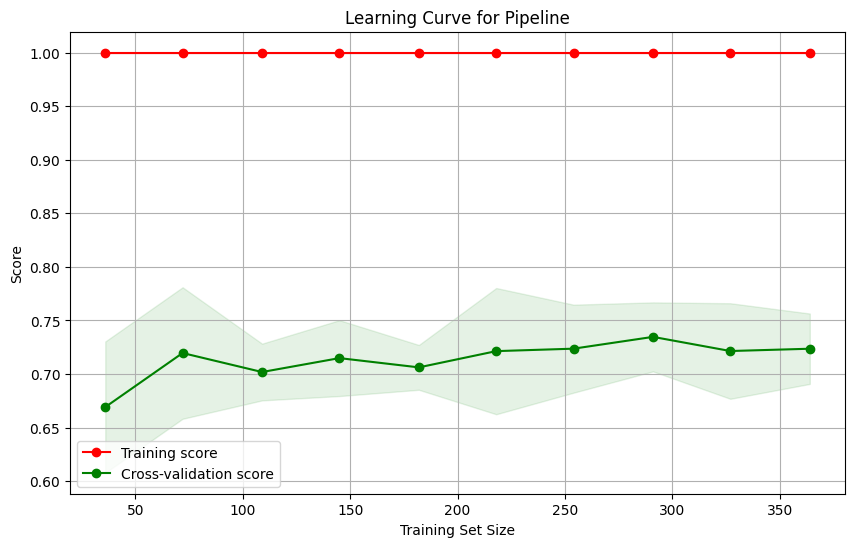

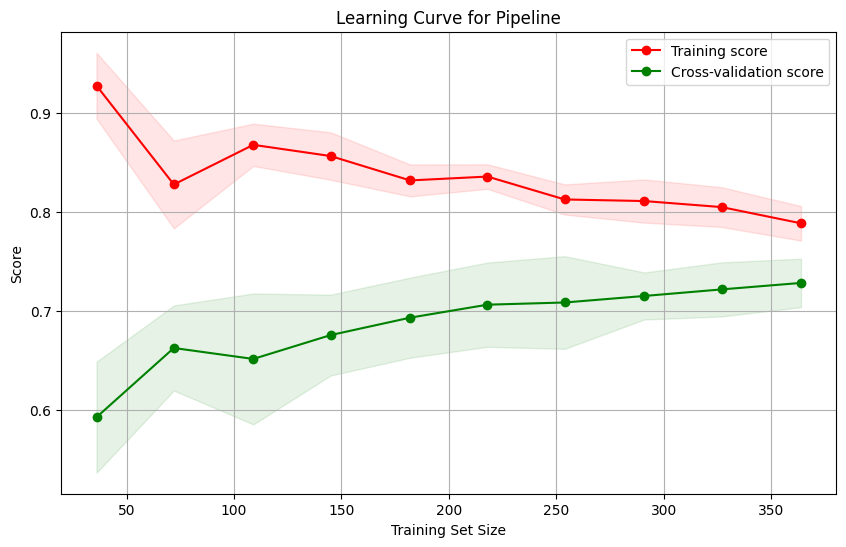

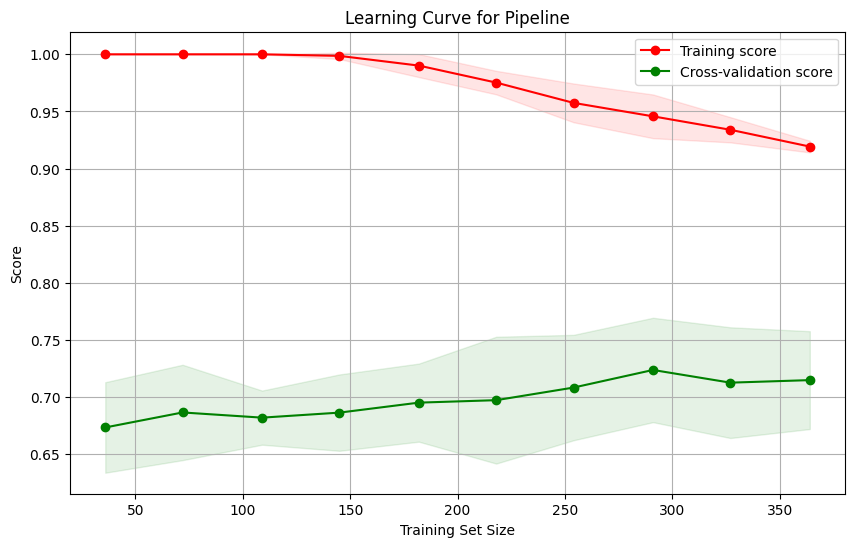

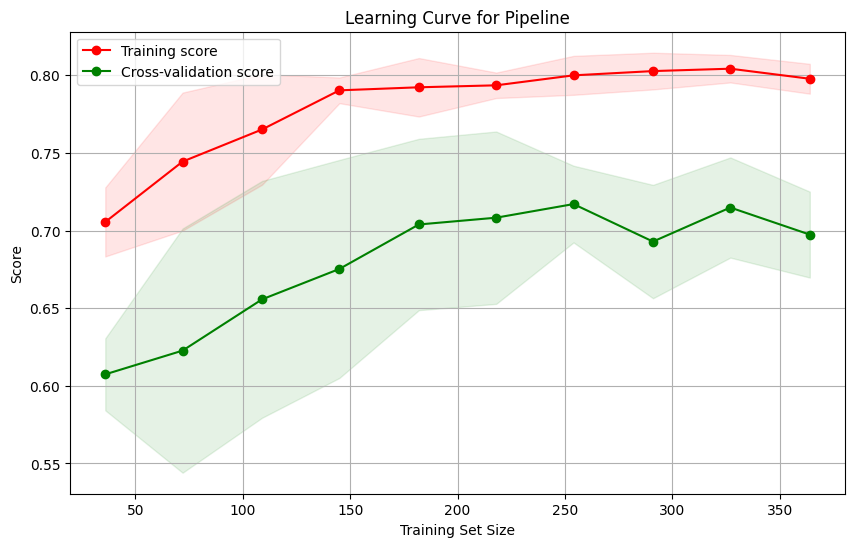

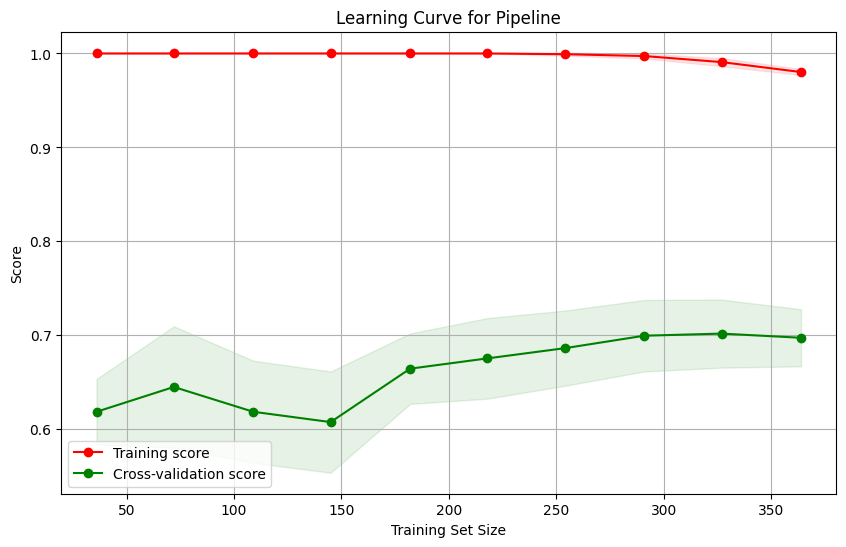

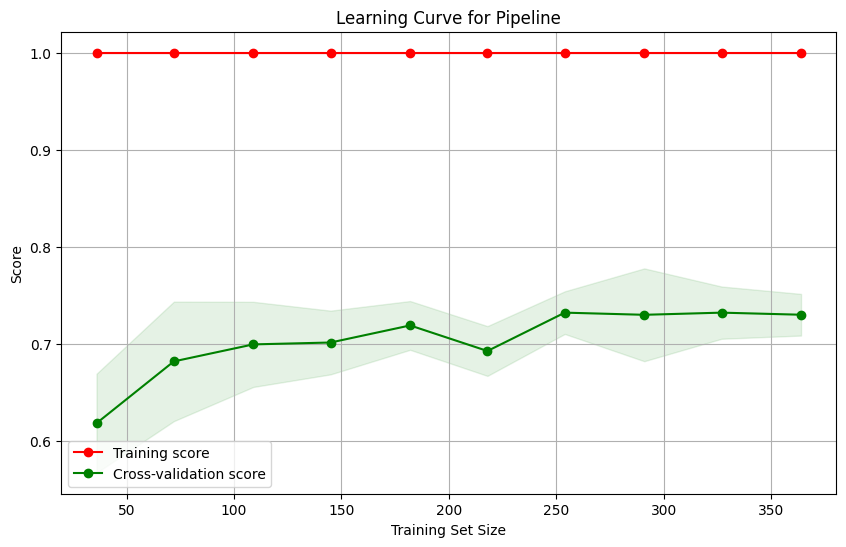

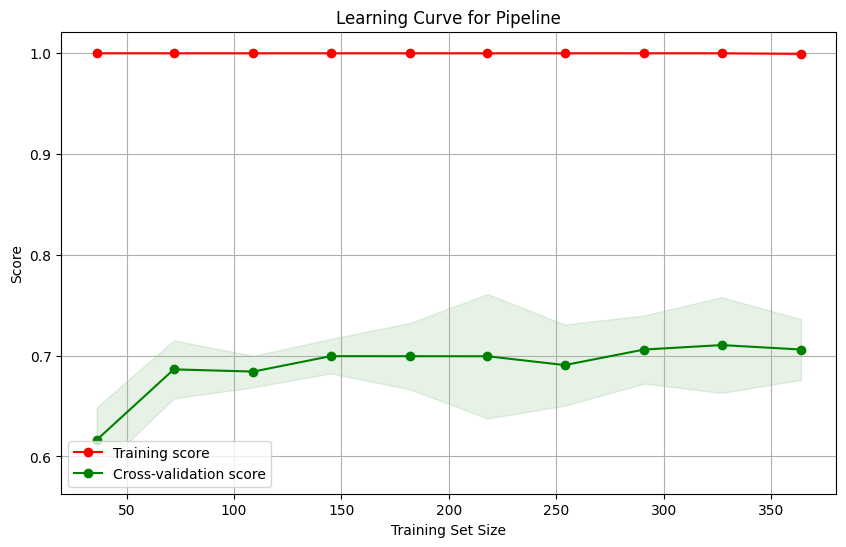

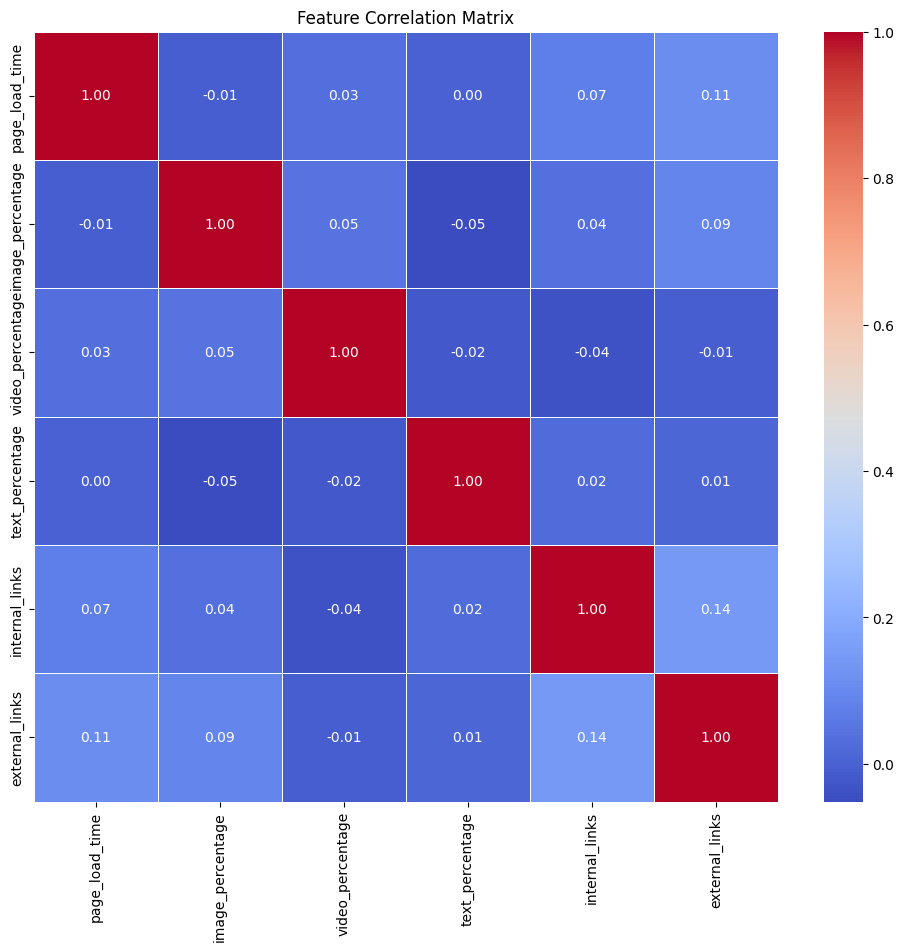

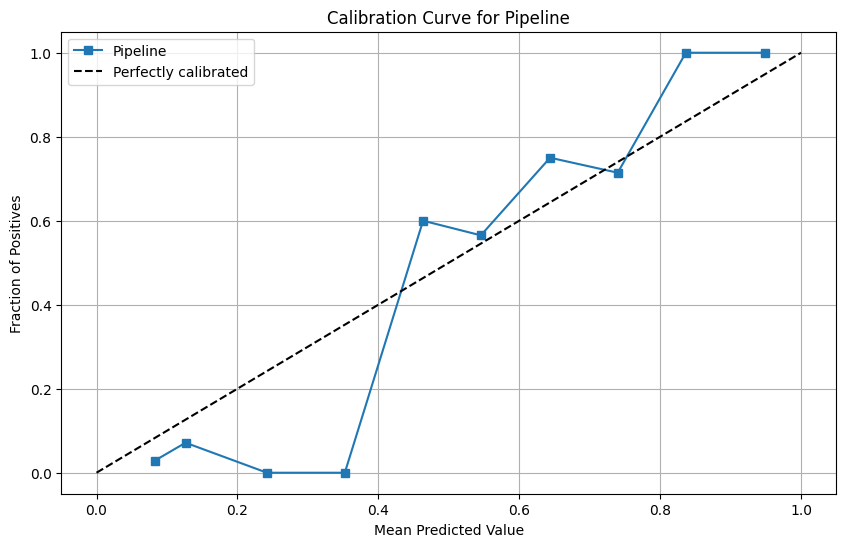

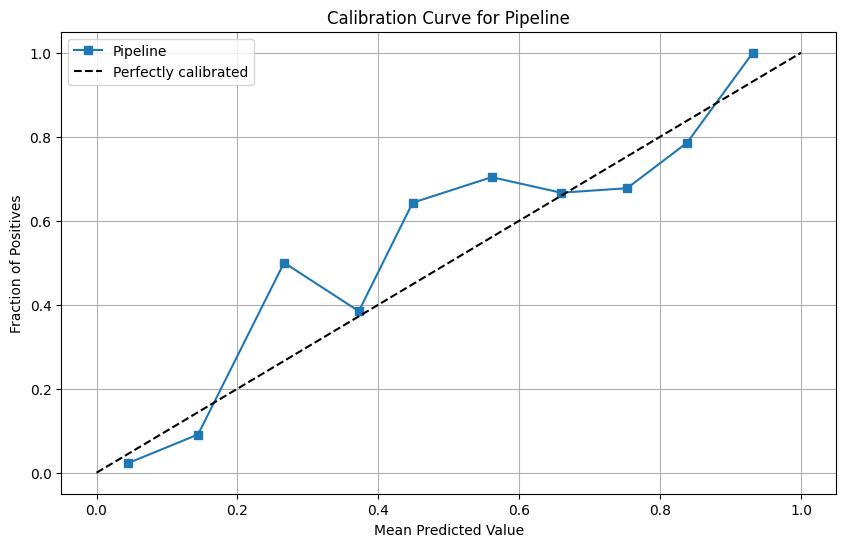

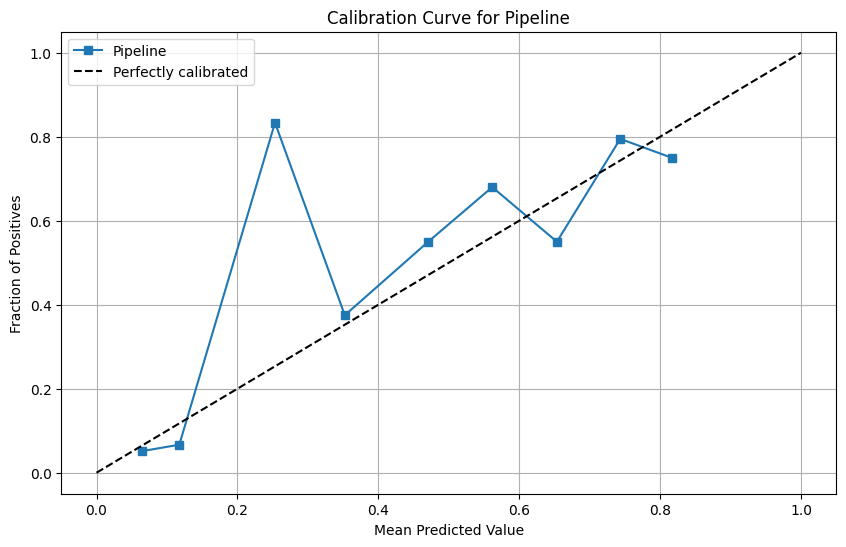

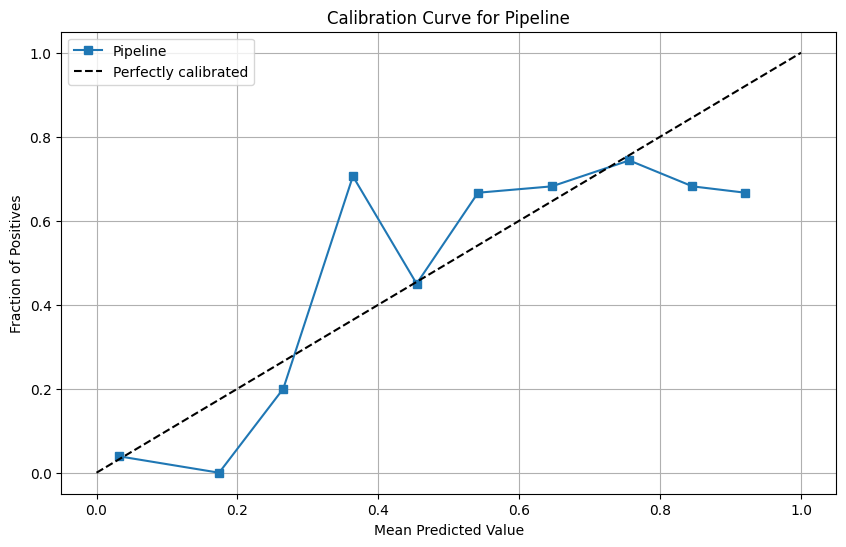

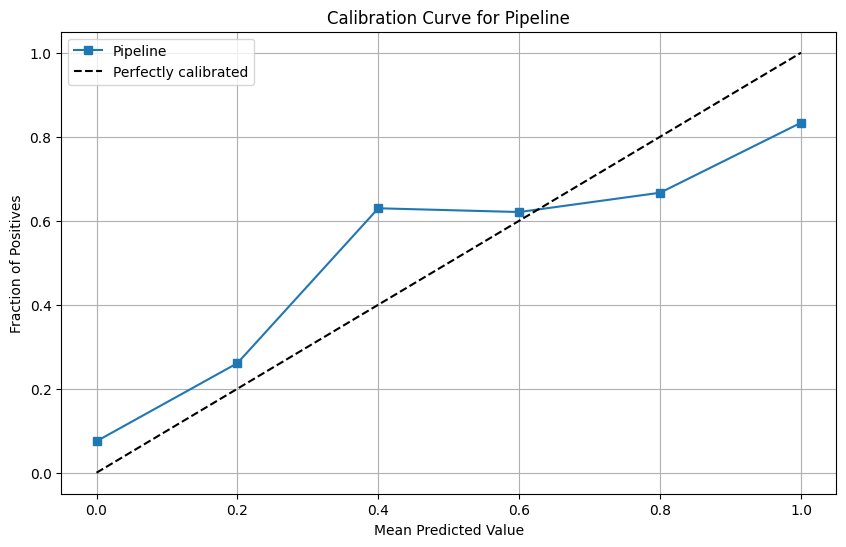

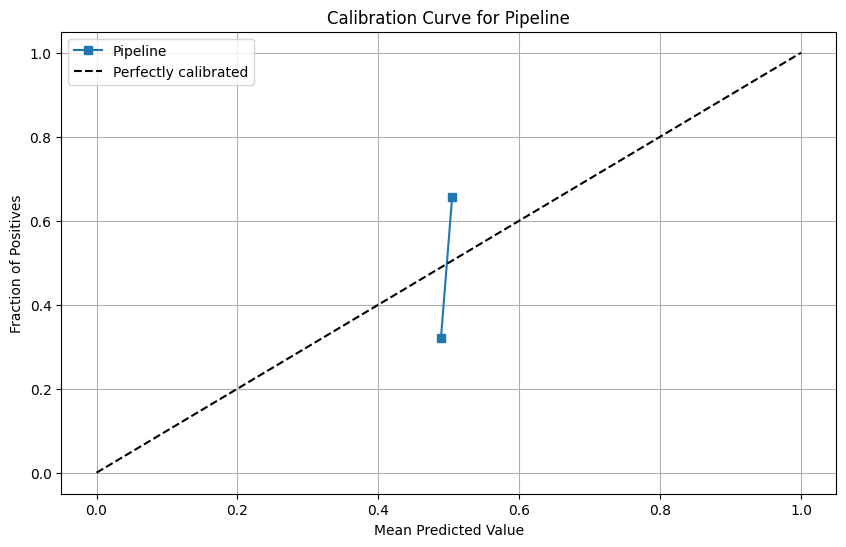

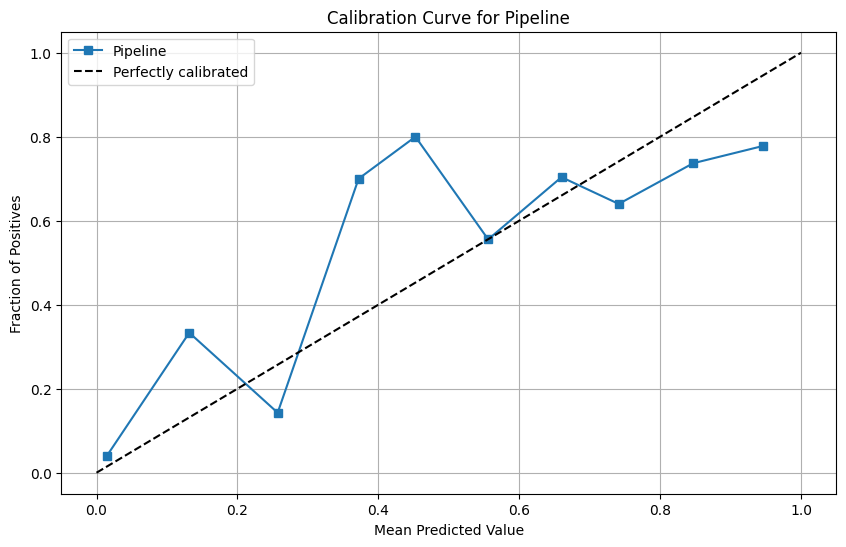

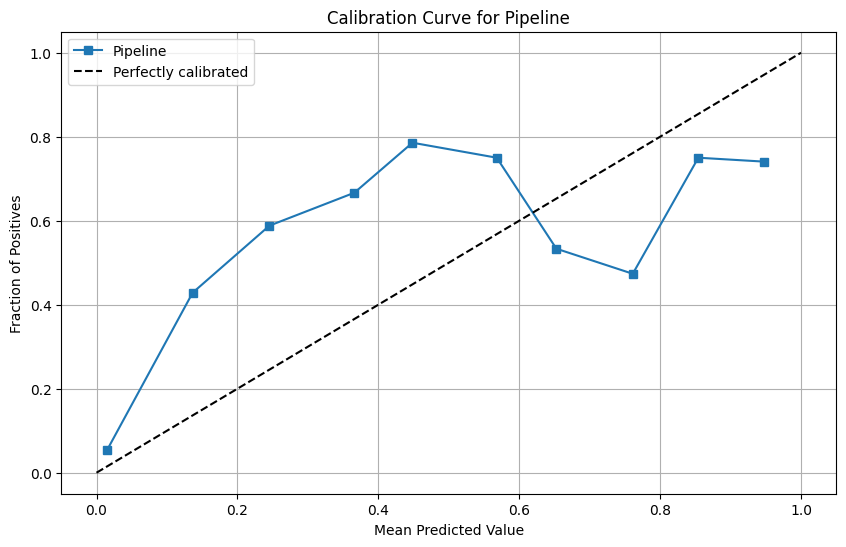

<Figure size 1200x1000 with 0 Axes>

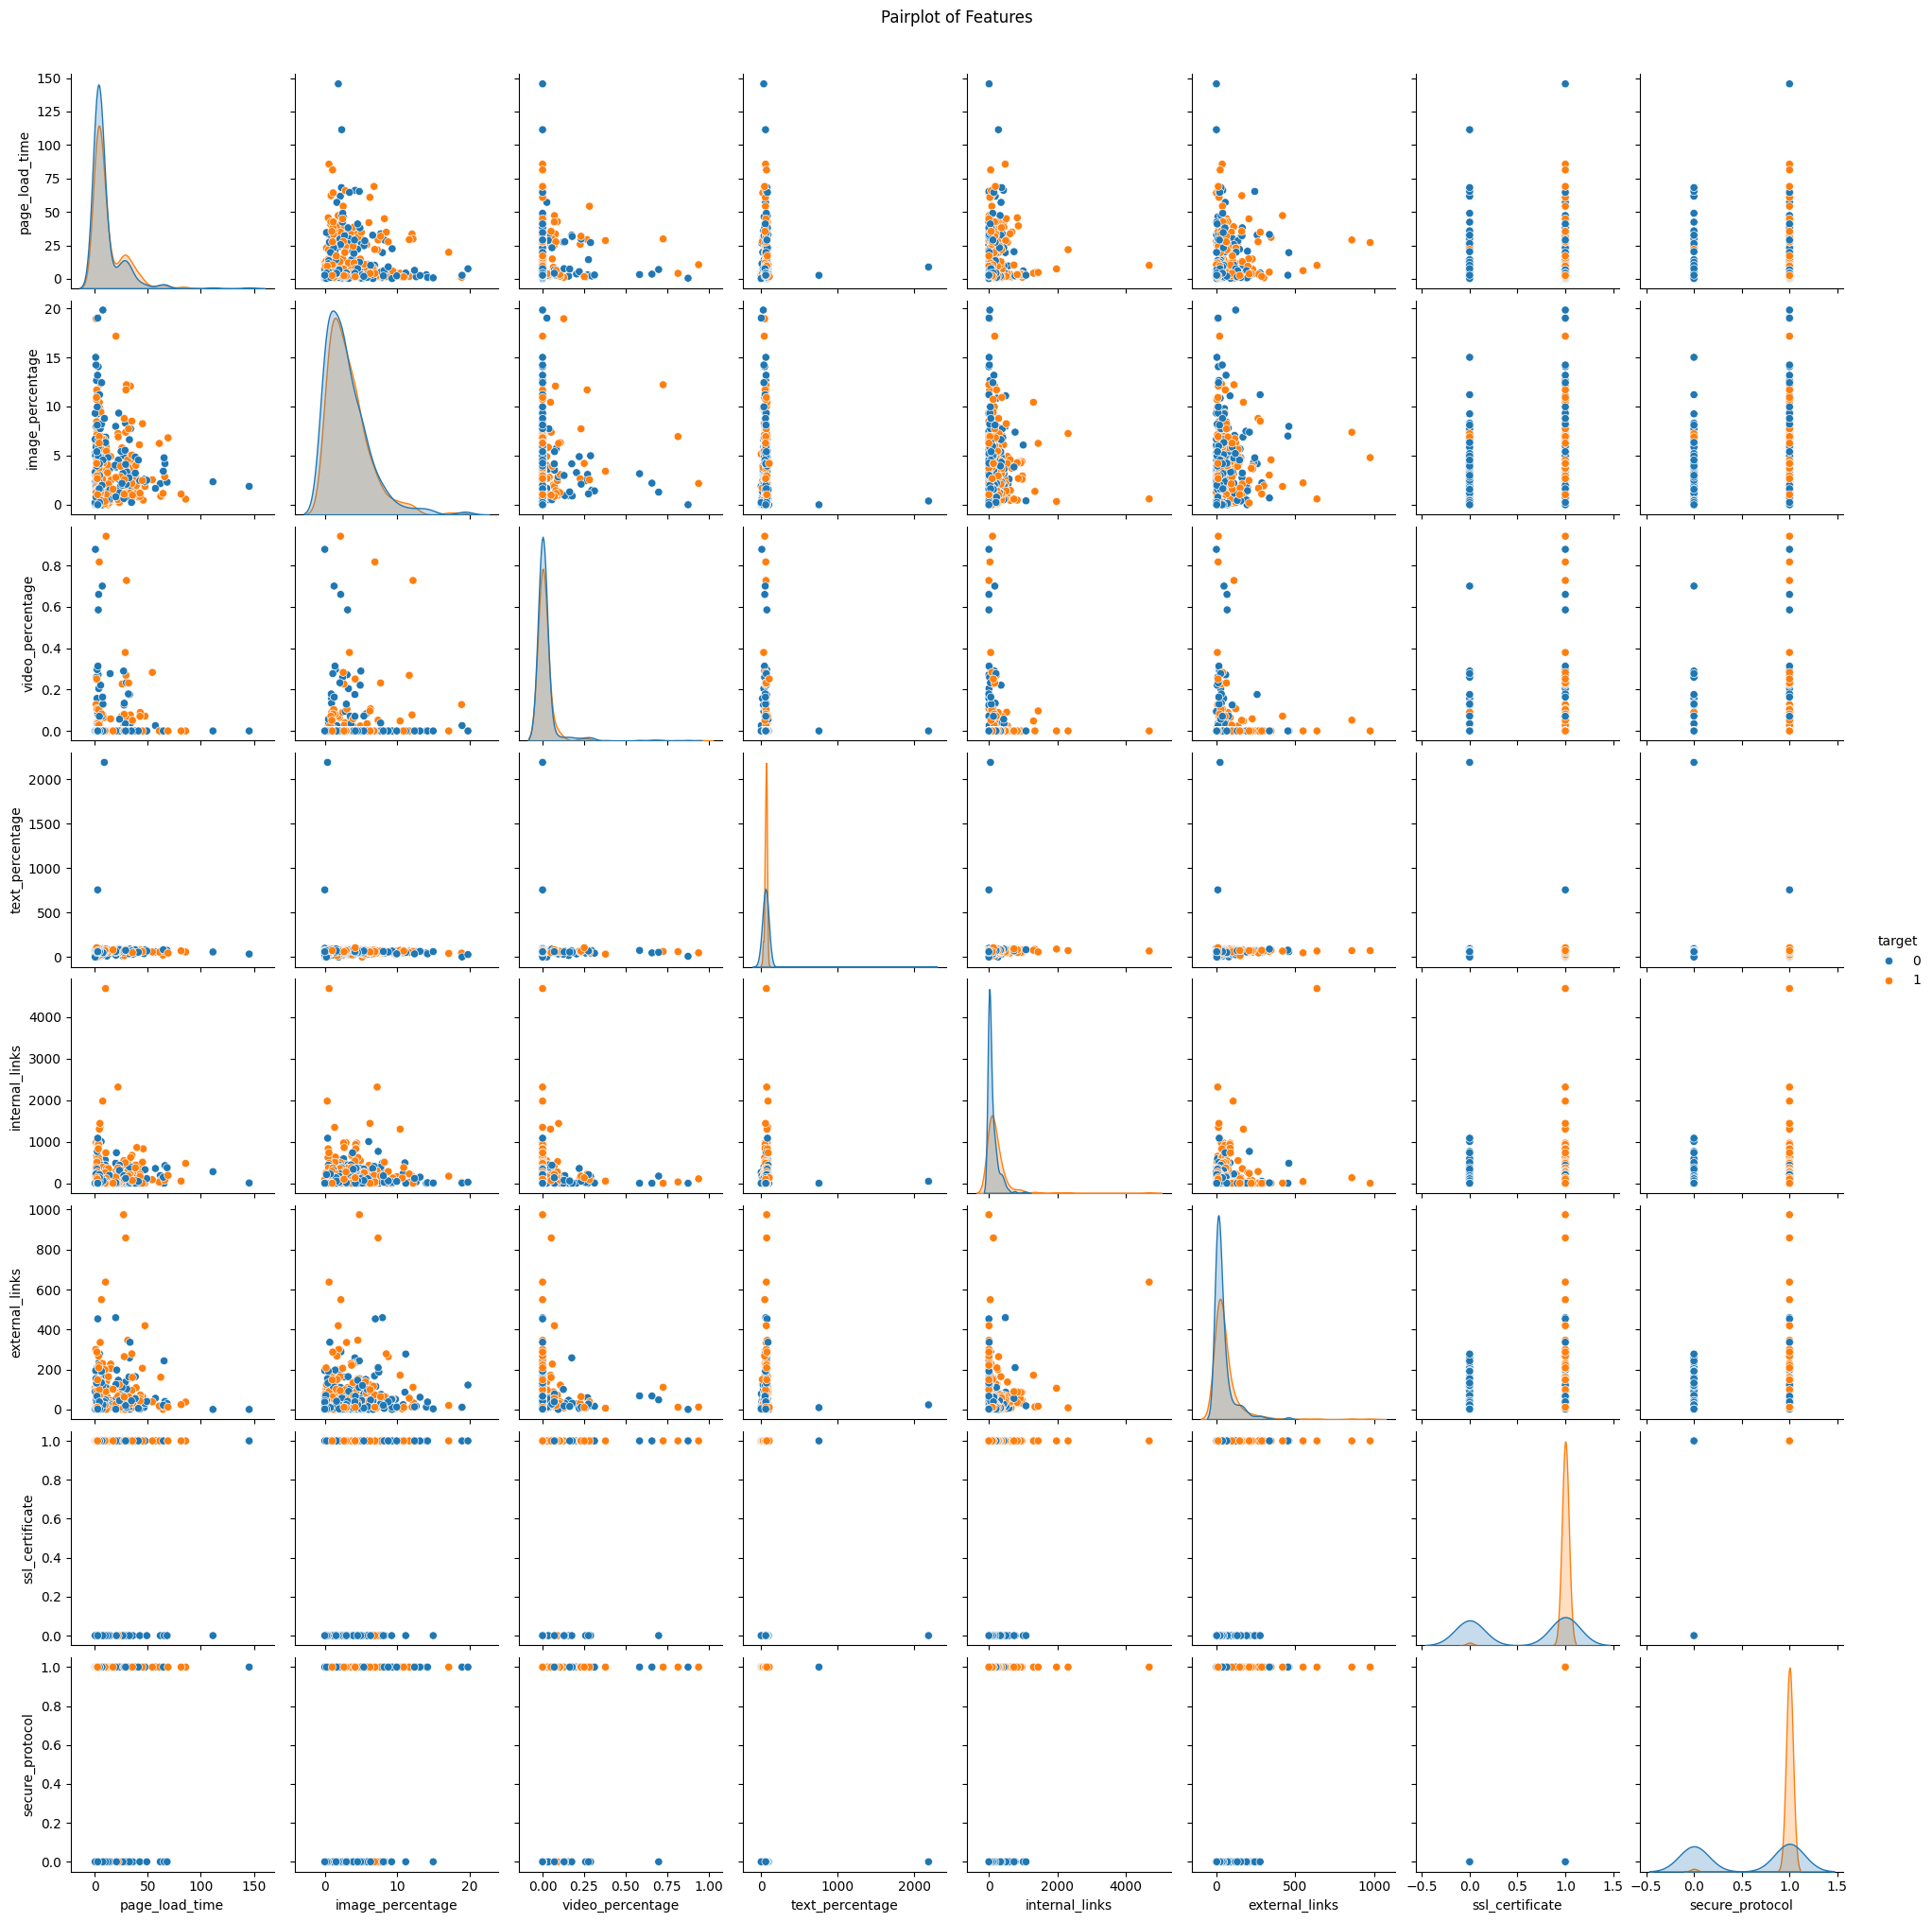

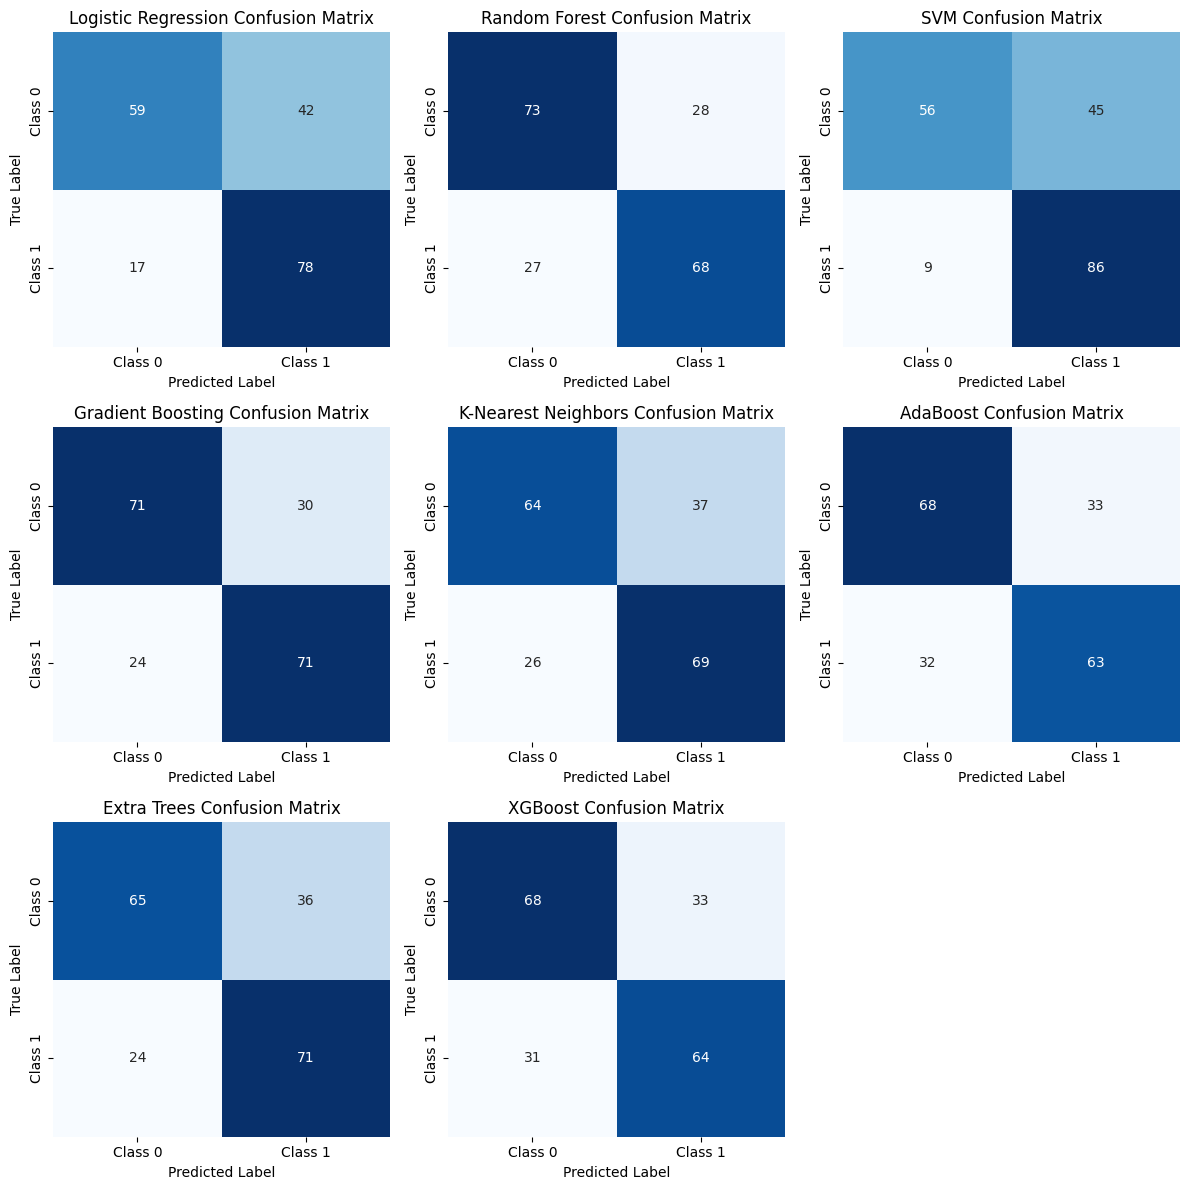

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.78      0.58      0.67       101
           1       0.65      0.82      0.73        95

    accuracy                           0.70       196
   macro avg       0.71      0.70      0.70       196
weighted avg       0.72      0.70      0.70       196

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.73      0.72      0.73       101
           1       0.71      0.72      0.71        95

    accuracy                           0.72       196
   macro avg       0.72      0.72      0.72       196
weighted avg       0.72      0.72      0.72       196

Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.86      0.55      0.67       101
           1       0.66      0.91      0.76        95

    accuracy                           0.72       196
   mac

In [12]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix,
    classification_report, precision_recall_curve
)
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import LabelEncoder
# Step 2: Load Your Data
data = pd.read_csv('cleaned.csv')  # Update with your dataset path

columns_to_exclude = ['indexing_status', 'label', 'url', 'ssl_issuer', 'ssl_subject', 'ssl_not_before', 'ssl_not_after', 'domain']
X = data.drop(columns=columns_to_exclude)
y = data['indexing_status']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y) 
# Step 3: Identify Categorical and Numerical Columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['number']).columns

# # Step 4: Define Features and Target Variable
# X = data.drop(columns='target')  # Replace 'target' with your actual target column name
# y = data['target']  # Assuming 'target' is the column name for your target variable

# Encode categorical features using OneHotEncoder with handle_unknown set to 'ignore'
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),  # Set handle_unknown='ignore'
        ('num', StandardScaler(), numerical_cols)
    ]
)


# Step 6: Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 7: Define Models and Hyperparameters
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {'classifier__C': [0.1, 1, 10]}  # Corrected parameter key
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'classifier__n_estimators': [50, 100, 200]}  # Corrected parameter key
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}  # Corrected parameter key
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 1]}  # Corrected parameter key
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {'classifier__n_neighbors': [3, 5, 7]}  # Corrected parameter key
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'params': {'classifier__n_estimators': [50, 100, 200]}  # Corrected parameter key
    },
    'Extra Trees': {
        'model': ExtraTreesClassifier(random_state=42),
        'params': {'classifier__n_estimators': [50, 100, 200]}  # Corrected parameter key
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42),
        'params': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 0.2]}  # Corrected parameter key
    }
}


# Step 8: Function for Training and Tuning Models
def train_and_tune_model(name, model, params):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    grid_search = GridSearchCV(pipeline, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Step 9: Train and Tune Models
best_models = {}
for name, model_info in models.items():
    model, params = model_info['model'], model_info['params']
    best_model, best_params = train_and_tune_model(name, model, params)
    best_models[name] = best_model

# Step 10: Predictions
y_preds = {}
for name, model in best_models.items():
    y_preds[name] = model.predict(X_test)

# Step 11: Error Plots
plt.figure(figsize=(12, 6))
for name, y_pred in y_preds.items():
    error = np.abs(y_test - y_pred)
    plt.plot(error, label=name)
plt.title('Error Plot')
plt.xlabel('Sample Index')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

# Step 12: ROC Curves
plt.figure(figsize=(12, 6))
for name, model in best_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# Step 13: Precision-Recall Curves
plt.figure(figsize=(12, 6))
for name, model in best_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=name)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Step 14: Learning Curves
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
    plt.xlabel('Training Set Size')
    plt.ylabel('Score')
    plt.title(f'Learning Curve for {model.__class__.__name__}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plot learning curves for each model
for name, model in best_models.items():
    plot_learning_curve(model, X_train, y_train)

# Step 15: Feature Correlation Matrix
# Select only numeric columns for correlation
numeric_X = X.select_dtypes(include=['number'])

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_X.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()


# Step 16: Calibration Curves
def plot_calibration_curve(model, X, y):
    y_prob = model.predict_proba(X)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y, y_prob, n_bins=10, strategy='uniform')
    
    plt.figure(figsize=(10, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, 's-', label=f'{model.__class__.__name__}')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    plt.xlabel('Mean Predicted Value')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve for {model.__class__.__name__}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plot calibration curves for each model
for name, model in best_models.items():
    plot_calibration_curve(model, X_test, y_test)

# Step 17: Feature Importances
def plot_feature_importances(model, X):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Feature Importances for {model.__class__.__name__}')
        plt.bar(range(X.shape[1]), importances[indices], align='center')
        plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
        plt.xlim([-1, X.shape[1]])
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.grid(True)
        plt.show()

# Plot feature importances for each model
for name, model in best_models.items():
    plot_feature_importances(model, X_train)

# Step 18: Pairplot
plt.figure(figsize=(12, 10))
data_with_target = X.copy()
data_with_target['target'] = y
sns.pairplot(data_with_target, hue='target', diag_kind='kde')
plt.suptitle('Pairplot of Features', y=1.02)
plt.show()

# Step 19: Confusion Matrix and Classification Reports
plt.figure(figsize=(12, 12))
for i, (name, model) in enumerate(best_models.items()):
    y_pred = model.predict(X_test)
    plt.subplot(3, 3, i + 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Step 20: Print Classification Reports
for name, model in best_models.items():
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, model.predict(X_test)))
